# Stroke Predictor - DSCI 100 Group Project Proposal

## Introduction

The chances of getting a stroke can often be predicted by certain factors such as glucose level and smoking status. Being able to tell a person if they are categorized to have a higher chance of stroke gives a person a chance to reduce said factors in hopes of preventing a stroke. The question and purpose of our project is to classify a large set of data that gives the factors that lead to stroke and then, when given a new example, predict if the person is likely to have a stroke.
The data set is provided on Kaggle (https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset), which lists various background clinical features from the patients, such as disease history and age, all potentially useful in predicting a stroke. 

Below are some preliminary exploratory data analysis to visualize the data before classifying it.

In [1]:
### LOADING LIBRARY

### Run this cell before continuing.
library(plyr)
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
# install.packages("randomForest")
# library(randomForest)
install.packages("themis")
 library(themis)

options(repr.matrix.max.rows = 6)


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::arrange()   masks plyr::arrange()
✖ purrr::compact()   masks plyr::compact()
✖ dplyr::count()     masks plyr::count()
✖ dplyr::failwith()  masks plyr::failwith()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::id()        masks plyr::id()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::mutate()    masks plyr::mutate()
✖ dplyr::rename()    masks plyr::rename()
✖ dplyr::summarise() masks plyr::summarise()
✖ dplyr::summarize() masks plyr::summarize()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ mod

Read dataset from web into R

In [2]:
url <- "https://gist.githubusercontent.com/aishwarya8615/d2107f828d3f904839cbcb7eaa85bd04/raw/cec0340503d82d270821e03254993b6dede60afb/healthcare-dataset-stroke-data.csv"
stroke_data <- read_csv(url)

## modify variable types
stroke_data_final <- stroke_data |>
                    mutate (stroke = as.factor(stroke),
                           bmi = as.numeric(bmi))
stroke_data_final

Rows: 5110 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): gender, ever_married, work_type, Residence_type, bmi, smoking_status
dbl (6): id, age, hypertension, heart_disease, avg_glucose_level, stroke

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<fct>
9046,Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61,0,0,Yes,Self-employed,Rural,202.21,NA,never smoked,1
31112,Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
19723,Female,35,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
37544,Male,51,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0
44679,Female,44,0,0,Yes,Govt_job,Urban,85.28,26.2,Unknown,0


To view what correlation various factors have on developing stroke, we will plot three scatter graphs: age vs. average glucose level, age vs. BMI, and BMI vs. average glucose level. These three variables were chosen because they were continuous measurements and are closely related to the develpopment of stroke. 

Splitting the dataset into training and testing datasets based on stroke history

In [3]:
set.seed(1)

stroke_split <- initial_split(stroke_data_final, prop = 0.75, strata = stroke)
stroke_train <- training(stroke_split)
stroke_test <- testing(stroke_split) 

Preliminary Summary

The tables below show the min and the max of each continous feature when a person has or has not a stroke

In [4]:
continous_factors <- select(stroke_train, bmi,avg_glucose_level,age,stroke)

factors_with_stroke <- filter(continous_factors, stroke == 1)
factors_without_stroke <- filter(continous_factors, stroke == 0)


min_max <- list(
  min = ~min(.x, na.rm = TRUE), 
  max = ~max(.x, na.rm = TRUE)
)

avg <- list(
  avg = ~mean(.x, na.rm = TRUE)
)



factors_with_stroke |> summarise(across(where(is.numeric), min_max))
factors_without_stroke |> summarise(across(where(is.numeric), min_max))




bmi_min,bmi_max,avg_glucose_level_min,avg_glucose_level_max,age_min,age_max
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
16.9,56.6,57.92,271.74,1.32,82


bmi_min,bmi_max,avg_glucose_level_min,avg_glucose_level_max,age_min,age_max
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
10.3,97.6,55.22,267.76,0.08,82


The tables below show the average of each continous feature when people have or have not a stroke

In [5]:
factors_with_stroke |> summarise(across(where(is.numeric), avg))
factors_without_stroke |> summarise(across(where(is.numeric), avg))

bmi_avg,avg_glucose_level_avg,age_avg
<dbl>,<dbl>,<dbl>
30.53095,133.4256,67.83837


bmi_avg,avg_glucose_level_avg,age_avg
<dbl>,<dbl>,<dbl>
28.8303,104.4644,42.10972


The table below shows how many cells with missing data are present in each column. This is imoprtant as we need to exclude any examples which may have incomplete data

In [6]:
stroke_bmi <- sum(is.na(factors_with_stroke$bmi))
stroke_avg_glucos <- sum(is.na(factors_with_stroke$avg_glucose_level))
stroke_age <- sum(is.na(factors_with_stroke$age))
no_stroke_bmi <- sum(is.na(factors_without_stroke$bmi))
no_stroke_averge_glucose <- sum(is.na(factors_without_stroke$avg_glucose_level))
no_stroke_age <- sum(is.na(factors_without_stroke$age))

missing_data <- tibble("With stroke: Bmi" = stroke_bmi, "With stroke: Avg Glucose" = stroke_avg_glucos, "With stroke: Age" = stroke_bmi, 
            "Without stroke: Bmi" = no_stroke_bmi, "Without stroke: Avg Glucose" = no_stroke_averge_glucose, "Without stroke: Age" = no_stroke_age)
missing_data

With stroke: Bmi,With stroke: Avg Glucose,With stroke: Age,Without stroke: Bmi,Without stroke: Avg Glucose,Without stroke: Age
<int>,<int>,<int>,<int>,<int>,<int>
28,0,28,118,0,0


Preliminary data Visualization

Warning message:
“Removed 146 rows containing missing values (geom_point).”
Warning message:
“Removed 146 rows containing missing values (geom_point).”


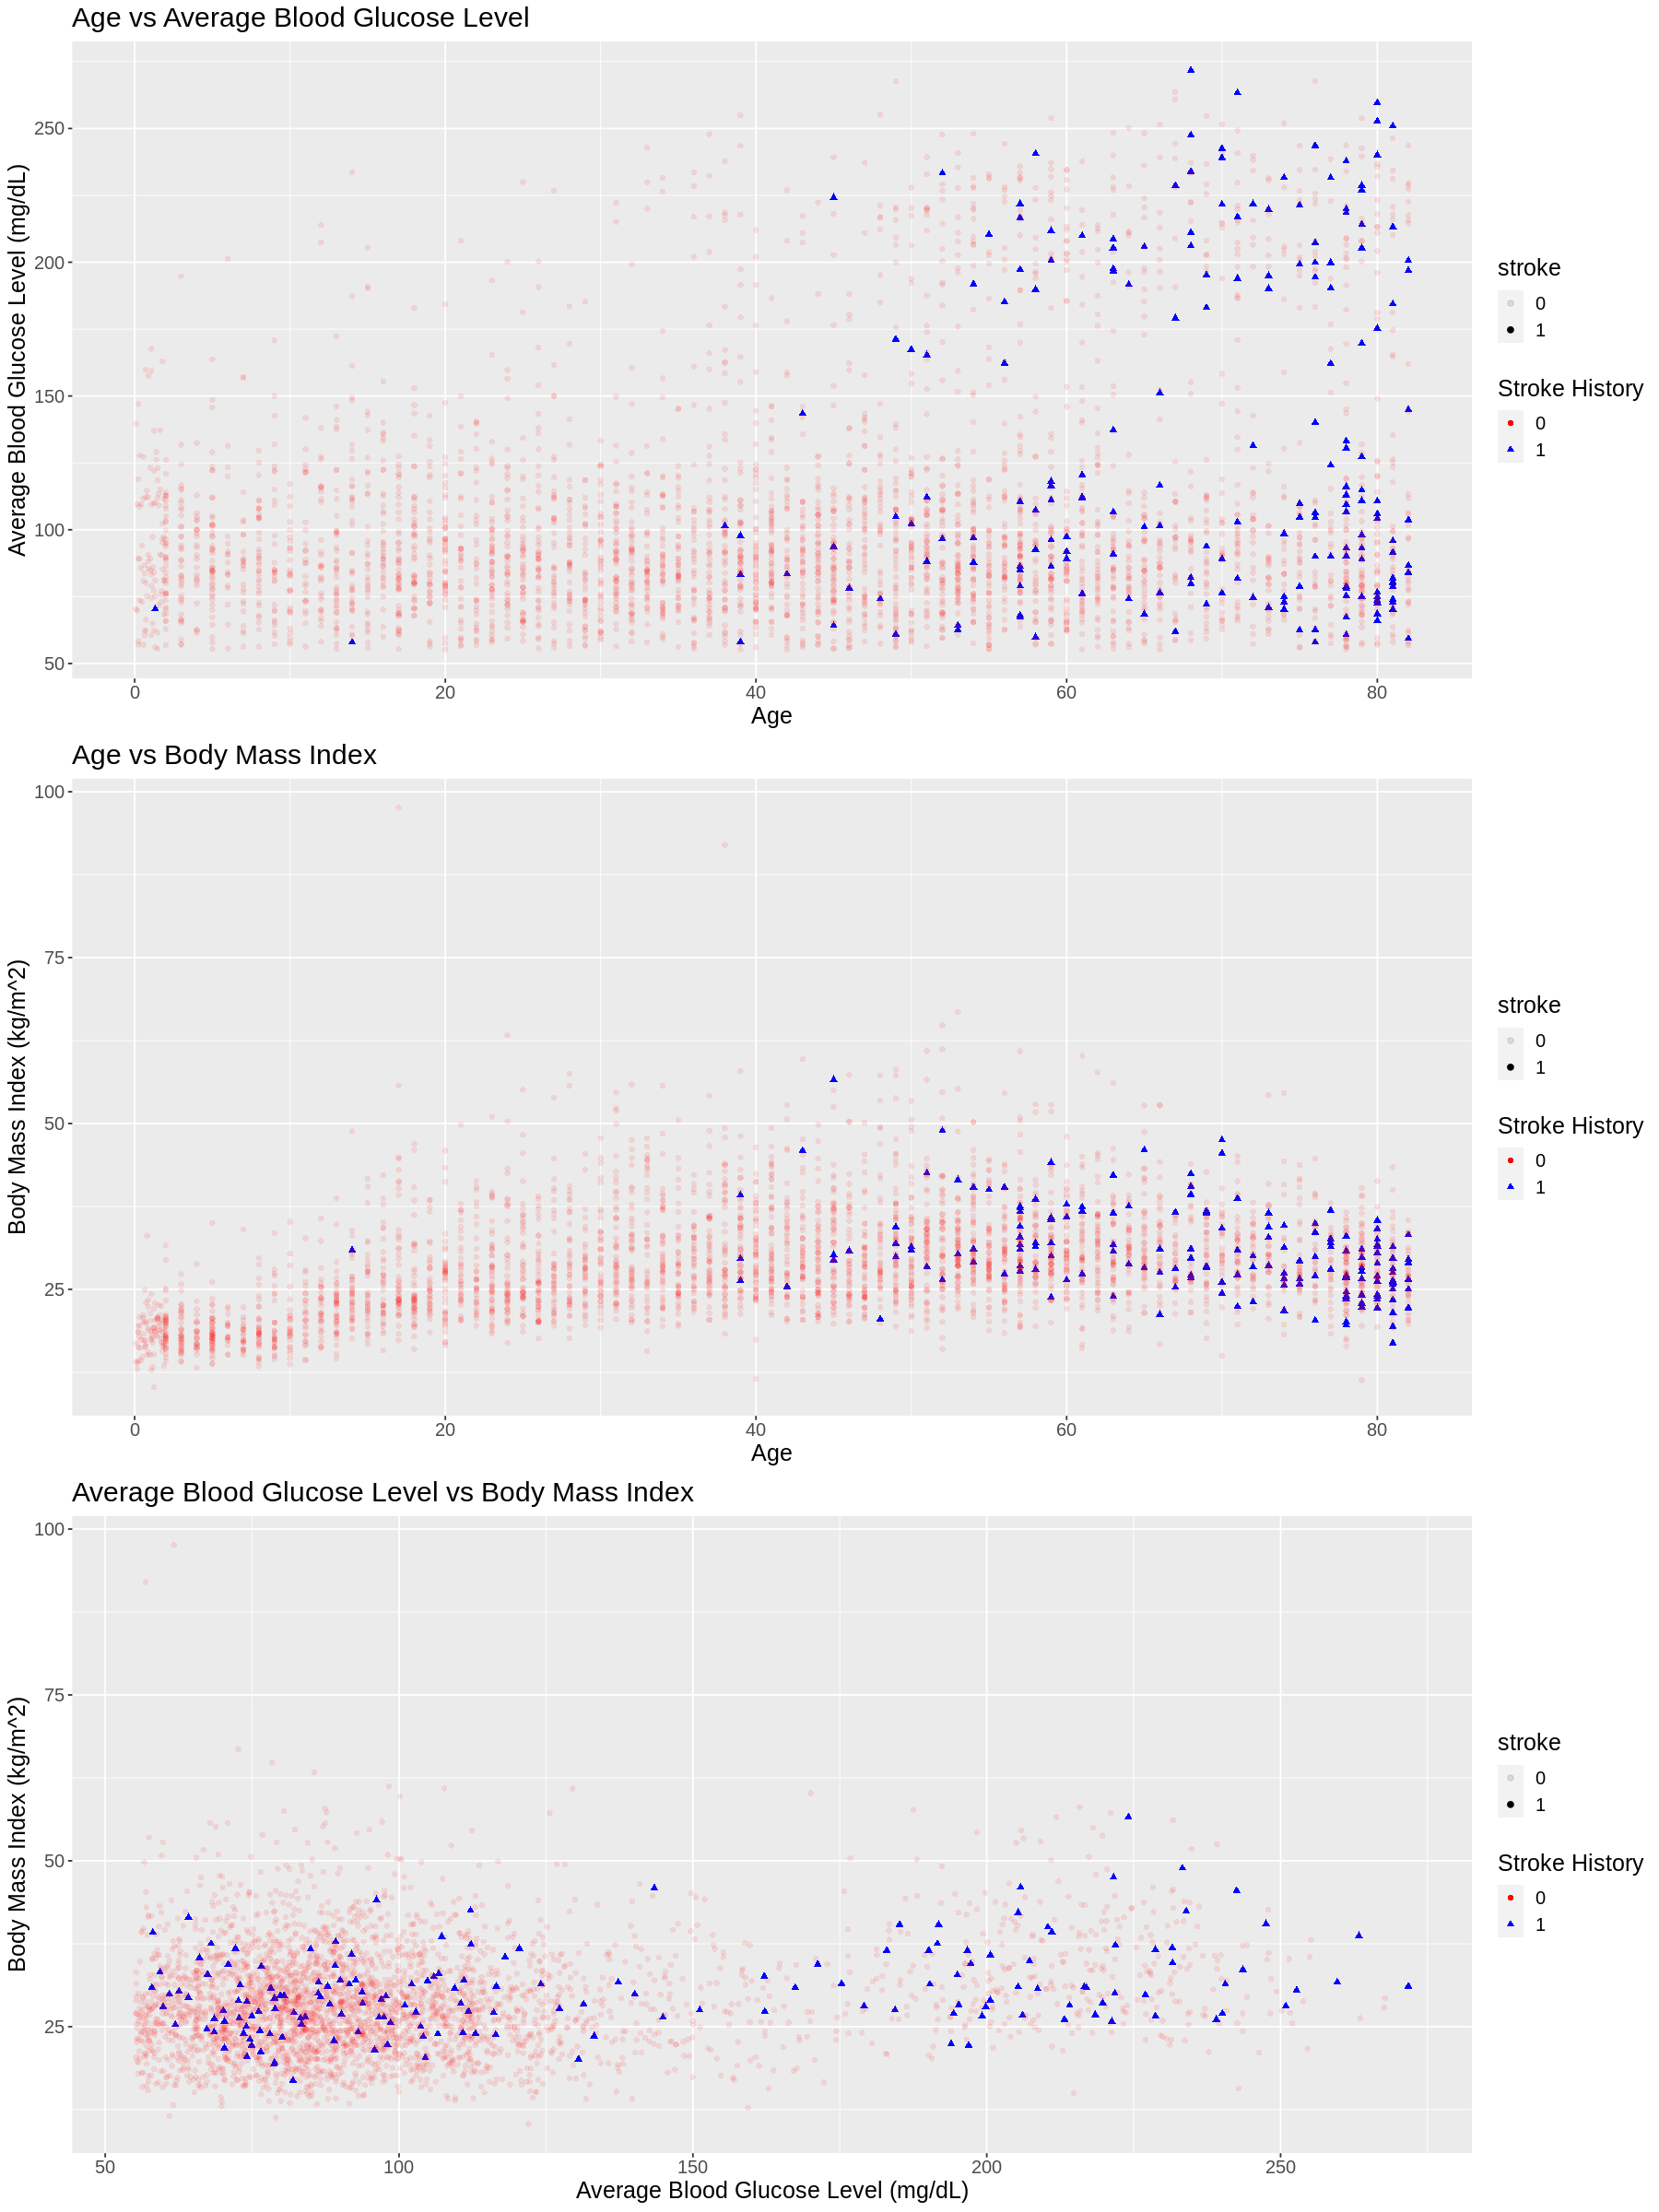

In [7]:
options(repr.plot.width = 20, repr.plot.height = 20)

age_vs_glucose <- ggplot (stroke_train, aes(x=age, y=avg_glucose_level, color= stroke,shape= stroke))+
                geom_point(aes(alpha = stroke,shape= stroke))+
                scale_alpha_manual(values = c(0.1, 1))+
                scale_color_manual(values = c("red", "blue"))+
                labs(x="Age", y="Average Blood Glucose Level (mg/dL)", color = "Stroke History",shape = "Stroke History")+
                ggtitle("Age vs Average Blood Glucose Level")+
                theme(text = element_text(size = 15))
options(repr.plot.width = 15, repr.plot.length = 20)

age_vs_bmi <- ggplot (stroke_train, aes(x=age, y=bmi, color= stroke,shape=stroke))+
                geom_point(aes(alpha = stroke,shape=stroke))+
                scale_alpha_manual(values = c(0.1, 1))+
                scale_color_manual(values = c("red", "blue"))+
                labs(x="Age", y="Body Mass Index (kg/m^2)", color = "Stroke History",shape = "Stroke History")+
                ggtitle("Age vs Body Mass Index")+
                theme(text = element_text(size = 15))
options(repr.plot.width = 15, repr.plot.length = 20)

avg_glucose_vs_bmi <- ggplot (stroke_train, aes(x=avg_glucose_level, y=bmi, color= stroke,shape=stroke))+
                geom_point(aes(alpha = stroke,shape=stroke))+
                scale_alpha_manual(values = c(0.1, 1))+
                scale_color_manual(values = c("red", "blue"))+
                labs(x="Average Blood Glucose Level (mg/dL)", y="Body Mass Index (kg/m^2)", color = "Stroke History",shape = "Stroke History")+
                ggtitle("Average Blood Glucose Level vs Body Mass Index")+
                theme(text = element_text(size = 15))
options(repr.plot.width = 15, repr.plot.length = 20)

plot_grid(age_vs_glucose, age_vs_bmi, avg_glucose_vs_bmi, ncol = 1)

**Graph Analyses:**

**Age vs Average Blood Glucose Level** - Looking at the graph, we can see that there is a cluster of exmaples who experinced a stoke alongside a cluster of high blood glucose. There is another cluster where age is high as well but this to be expected. To have a cluster where there is also a cluster of high blood glucose means that there is a correlation between the two factors and can be related
    
**Age vs Body Mass Index** - Here we see a strong correlation between age and having a stroke, meaning the we can consider being at a older age brings a higher chance of a stroke

**Average Blood Glucose Level vs Body Mass Index** - Now comparing BMI and glucose level we can see two localized clusters when Body index mass is low and glucose levels is in the extreme low or high, this can be looked at further later.

### Methods

We use classification since we are more interested in predicting potential strokes rather than finding dependency relationship between stroke and other variables (regression). While the latter helps with finding out causes of stroke (and how strongly they contribute to stroke), classification provides useful warning as it allows the patient to be more aware of their lifestyle and doctors more proactive in diagnosis and treatment.

To build our model, we split our initial data so that 75% will be used in the training data and the rest for the test data. We also need to set a seed so that the code is reproducible. We will then build the model using the optimal K value found from applying cross-validation on the training data.

Three columns from the dataset will be used in this study: age, BMI, and average blood glucose level. These three variables are chosen not only because they are three important factors that contribute to an individual’s risk of developing stroke, but their continuous property makes it easier to establish the correlation with having a stroke. To visualize the relationship between the three factors and with stroke, we will produce three scatter plots: age vs. BMI, age vs. average blood glucose level, and finally BMI vs. average blood glucose level. All three plots will have datapoints color labeled to show the history of stroke (have had stroke or not).

In [8]:

# Set the seed 
set.seed(1)

stroke_data_final_selected<- stroke_data_final|> select(age,avg_glucose_level,bmi,stroke)|> drop_na()



#Training and Testing 
stroke_split <- initial_split(stroke_data_final_selected, prop = 0.75, strata = stroke)
stroke_train <- training(stroke_split)
stroke_test <- testing(stroke_split) 

# # Rebalance the traning data (first vision)
up_rec <- recipe(stroke ~ ., data = stroke_train) |>
   step_scale(all_predictors()) |>
   step_center(all_predictors()) |>
   step_downsample(stroke, under_ratio = 4) %>%
   prep()

stroke_train_balance <- up_rec %>%
  bake(new_data = NULL)




# # recipe // spec // workflow 
stroke_recipe<- recipe(stroke ~. , data = stroke_train_balance) |>
                                 step_scale(all_predictors()) |>
                                 step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
                              set_engine("kknn") |>
                              set_mode("classification")

 k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 10))
 stroke_vfold <- vfold_cv(stroke_train_balance, v = 5, strata = stroke)

knn_results <- workflow() |>
  add_recipe(stroke_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = stroke_vfold, grid = k_vals) |>
  collect_metrics() 

accuracies <- knn_results |>
  filter(.metric == "accuracy")


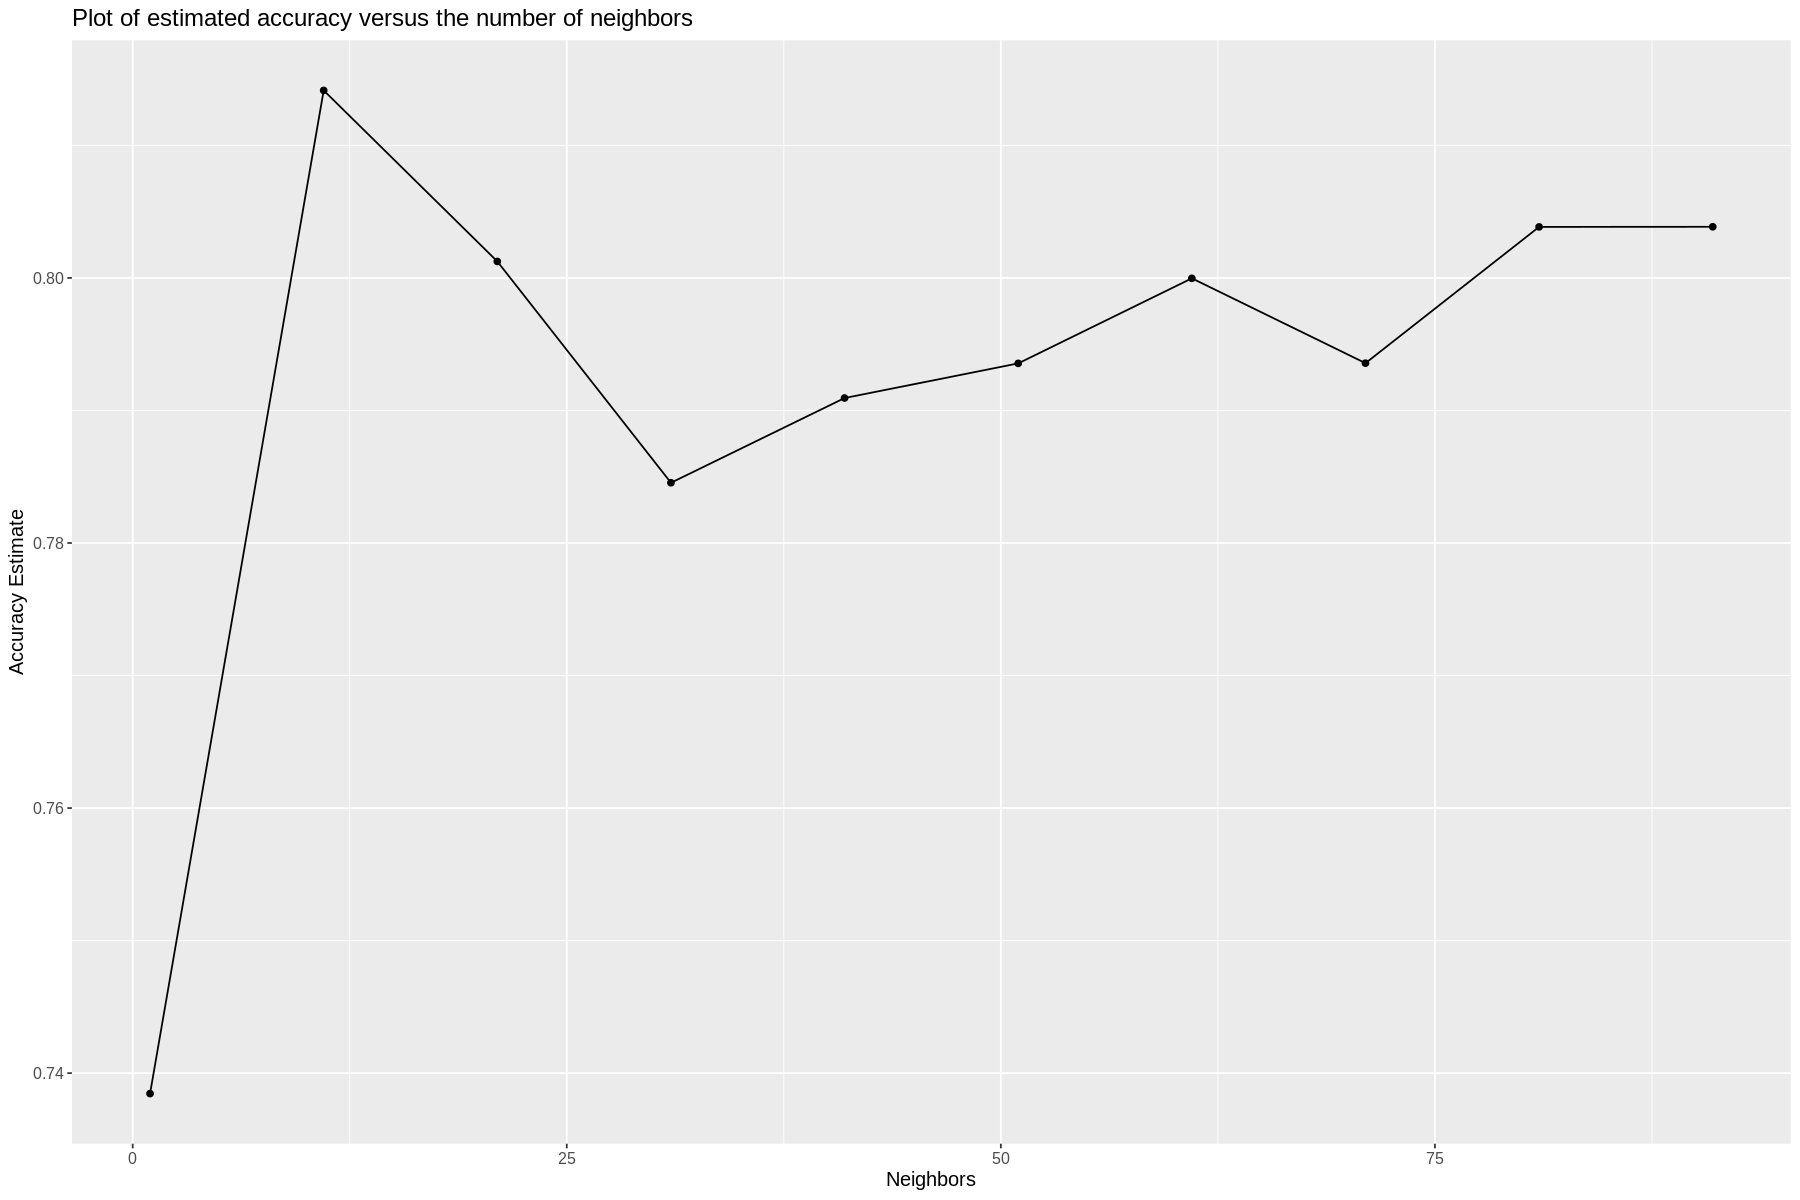

In [9]:
# K graph
options(repr.plot.height = 10, repr.plot.width = 15)
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12)) +
  ggtitle("Plot of estimated accuracy versus the number of neighbors")
accuracy_vs_k


In [10]:
# Choose the best K
accuracies<- accuracies|>arrange(desc(mean)) |> slice(1)
accuracies 

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
11,accuracy,binary,0.8141487,5,0.007543426,Preprocessor1_Model02


In [11]:
# Build the final model
k_min <- accuracies|>select(neighbors) |> pull()
knn_spec_final <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
       set_engine("kknn") |>
       set_mode("classification")

stroke_recipe_final<- recipe(stroke ~. , data = stroke_train) |>
                                 step_scale(all_predictors()) |>
                                 step_center(all_predictors())

stroke_fit <- workflow() |>
       add_recipe(stroke_recipe_final) |>
       add_model(knn_spec_final) |>
       fit(data = stroke_train)

In [20]:
# Get the accuracy
stroke_test_predictions <- predict(stroke_fit , stroke_test) |>
       bind_cols(stroke_test) 
stroke_test_predictions

stroke_accuracy <- stroke_test_predictions |>
       metrics(truth = stroke, estimate = .pred_class) |> filter(.metric == "accuracy")
stroke_accuracy

.pred_class,age,avg_glucose_level,bmi,stroke
<fct>,<dbl>,<dbl>,<dbl>,<fct>
0,80,105.92,32.5,1
0,81,186.21,29.0,1
0,74,70.09,27.4,1
⋮,⋮,⋮,⋮,⋮
0,1.08,79.15,17.4,0
0,68.00,91.68,40.8,0
0,45.00,97.95,24.5,0


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9568404


In [21]:
set.seed(1)

stroke_mat <- stroke_test_predictions |> 
       conf_mat(truth = stroke, estimate = .pred_class)

stroke_mat

          Truth
Prediction    0    1
         0 1175   53
         1    0    0

## Discussion

### Summary

Our model shows that that peak accuracy is obtained at $k = 11$ (using 11 nearest neighbors for classification). The model obtains roughly 96% accuracy when predicting strokes from new observations, which come from our split data for testing. 

### Expected outcomes

We expect the model to find more potential stroke cases among elderly people compared to young people. We expect BMI and age to also contribute to risks of stroke, albeit not as strong, but this is a regression problem that is not within our scope.

### Impact

The impact of the findings is directly linked to the main question of this report. With this classification model, we can now accurately predict whether a person is likely to develop a stroke or not and look into whether a part of their lifestyle is significantly contributing to this probability. This means that the medical team can be proactive in their treatments if such unfortunate events occur, and for the patient, promote a healthy lifestyle change.

### Future questions

By developing this stroke predictor, we hope to use a set of conditions that could potentially contribute to the development of strokes to predict whether an individual will develop their first stroke in the future. We will also examine the accuracy of this predictor for any future improvements. In a real-life setting, this predictor can be used for stroke prevention among high-risk patients and to promote lifestyle changes to reduce the risk of stroke. As this predictor only predicts the first stroke of an individual, while one in four stroke patients in the US (CDC, 2022) experiences a second stroke sometime in their life, future work can be done to predict the chance of having multiple strokes based on a more extensive range of health conditions and it could raise new inquiries regarding additional risk factors that could improve the model.

[FIXING]

## References 

https://www.cdc.gov/stroke/facts.htm

[ADD MORE HERE]